# Place365 Dataset Analysis (20K Subset)
 
In this notebook, we will analyze the distribution of a & b channel values, plot the histograms and print the mean and std values.

Found 20000 images in ./data_subset/train


Processing images: 100%|██████████| 20000/20000 [02:02<00:00, 163.69it/s]


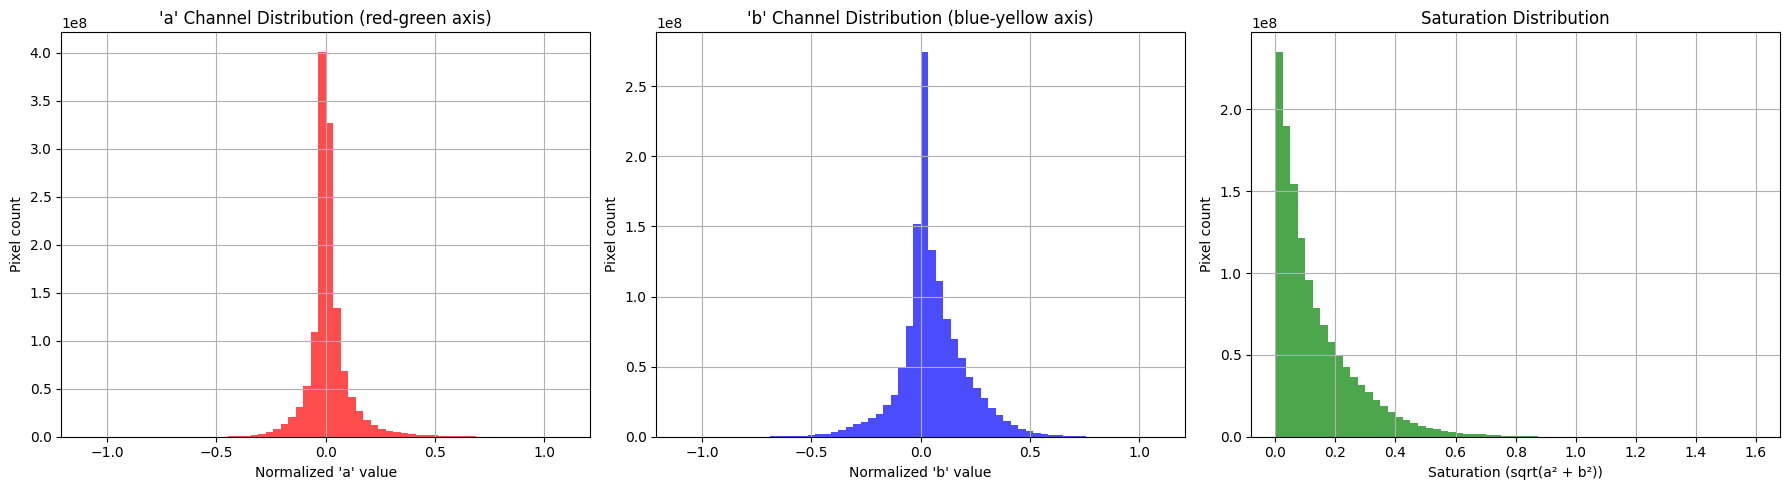


Statistics:
Total pixels analyzed: 1,310,720,000
'a' channel: mean bin = -0.006
'b' channel: mean bin = 0.037
Saturation: mean bin = 0.121


In [1]:
import os
from PIL import Image
import torch
import torchvision.transforms as T
import kornia.color as kc
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

rgb_dir = "./data_subset/train"
bins = 64
transform = T.Compose([T.ToTensor()])


a_range = (-1.1, 1.1)
b_range = (-1.1, 1.1)
sat_range = (0, 1.6)


a_hist = np.zeros(bins, dtype=np.int64)
b_hist = np.zeros(bins, dtype=np.int64)
sat_hist = np.zeros(bins, dtype=np.int64)


a_edges = np.linspace(a_range[0], a_range[1], bins + 1)
b_edges = np.linspace(b_range[0], b_range[1], bins + 1)
sat_edges = np.linspace(sat_range[0], sat_range[1], bins + 1)

filenames = [
    f for f in os.listdir(rgb_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))
]
print(f"Found {len(filenames)} images in {rgb_dir}")


for fname in tqdm(filenames, desc="Processing images"):
    img_path = os.path.join(rgb_dir, fname)
    img = Image.open(img_path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to("cuda")

    lab = kc.rgb_to_lab(img_t)[0]
    a = (lab[1, :, :] / 110.0).flatten().cpu().numpy()
    b = (lab[2, :, :] / 110.0).flatten().cpu().numpy()

    a_for_sat = lab[1, :, :] / 110.0
    b_for_sat = lab[2, :, :] / 110.0
    saturation = torch.sqrt(a_for_sat**2 + b_for_sat**2).flatten().cpu().numpy()

    a_hist += np.histogram(a, bins=a_edges)[0]
    b_hist += np.histogram(b, bins=b_edges)[0]
    sat_hist += np.histogram(saturation, bins=sat_edges)[0]

    del img_t, lab, a_for_sat, b_for_sat
    torch.cuda.empty_cache()


plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.bar(
    a_edges[:-1],
    a_hist,
    width=(a_edges[1] - a_edges[0]),
    color="red",
    alpha=0.7,
    align="edge",
)
plt.title("'a' Channel Distribution (red-green axis)")
plt.xlabel("Normalized 'a' value")
plt.ylabel("Pixel count")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.bar(
    b_edges[:-1],
    b_hist,
    width=(b_edges[1] - b_edges[0]),
    color="blue",
    alpha=0.7,
    align="edge",
)
plt.title("'b' Channel Distribution (blue-yellow axis)")
plt.xlabel("Normalized 'b' value")
plt.ylabel("Pixel count")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.bar(
    sat_edges[:-1],
    sat_hist,
    width=(sat_edges[1] - sat_edges[0]),
    color="green",
    alpha=0.7,
    align="edge",
)
plt.title("Saturation Distribution")
plt.xlabel("Saturation (sqrt(a² + b²))")
plt.ylabel("Pixel count")
plt.grid(True)

plt.tight_layout()
plt.show()


print(f"\nStatistics:")
print(f"Total pixels analyzed: {a_hist.sum():,}")
print(f"'a' channel: mean bin = {np.average(a_edges[:-1], weights=a_hist):.3f}")
print(f"'b' channel: mean bin = {np.average(b_edges[:-1], weights=b_hist):.3f}")
print(f"Saturation: mean bin = {np.average(sat_edges[:-1], weights=sat_hist):.3f}")

In [2]:
print(f"'a' channel: std bin = {np.std(a_edges[:-1]):.3f}")
print(f"'b' channel: std bin = {np.std(b_edges[:-1]):.3f}")
print(f"Saturation: std bin = {np.std(sat_edges[:-1]):.3f}")

'a' channel: std bin = 0.635
'b' channel: std bin = 0.635
Saturation: std bin = 0.462
